# Change-point Poisson Model
BS Vương Kiến Thanh

Hôm nay tôi xin giới thiệu mô hình Change-point Poisson Model. Nó thực chất là mô hình Poisson, nhưng tại một thời điểm cụ thể, tham số rate ($\lambda$) bị thay đổi.  
Bạn cũng có thể áp dụng mô hình này vào phân tích thời điểm thay đổi mà với phân phối biến kết cục là khác như normal, gamma.

Mô hình đơn giản có dạng:
$$ \begin{aligned}
\text{T} &\sim \text{Uniform}(\text{start}, \text{end}) \\
\alpha, \beta ... &\sim \text{Prior}\\
\log(\lambda_{group}) &\sim \alpha_{group} + \sum\beta x \quad&& \text{với } \text{group} = \{t<T; t \geq T\} \\
y_{group} &\sim \text{Poisson}(\lambda_{group})
\end{aligned}$$

## Data trong ví dụ:
Data có ở package `boot` trong https://cran.r-project.org/web/packages/boot/
<pre>
Description
The coal data frame has 191 rows and 1 columns.
This data frame gives the dates of 191 explosions in coal mines which resulted in 10 or more
fatalities. The time span of the data is from March 15, 1851 until March 22 1962.

Source  
The data were obtained from Hand, D.J., Daly, F., Lunn, A.D., McConway, K.J. and Ostrowski, E. (1994) A Handbook of Small Data Sets, Chapman and Hall.  

References
1. Davison, A.C. and Hinkley, D.V. (1997) Bootstrap Methods and Their Application. Cambridge University Press.  
2. Jarrett, R.G. (1979) A note on the intervals between coal-mining disasters. Biometrika, 66, 191-193.</pre>

In [500]:
import pyreadr
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.diagnostics import hpdi
az.style.use('fivethirtyeight')

In [407]:
data = pyreadr.read_r("../boot/data/coal.rda")['coal']
data.head()

,date
rownames,
1,1851.202601
2,1851.632444
3,1851.969199
4,1851.974675
5,1852.314168


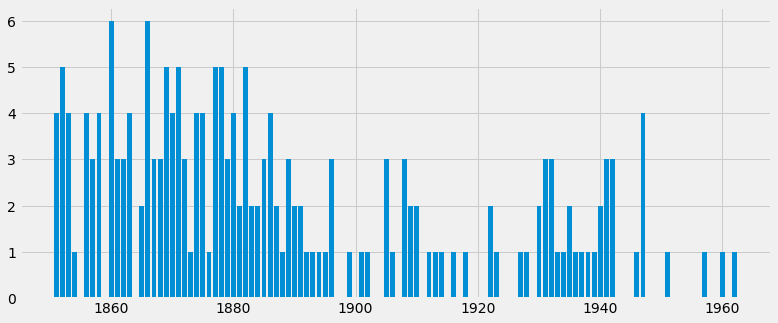

In [449]:
df = data['date'].astype(int).value_counts(sort=False).rename("count")
plt.figure(figsize=(12,5))
plt.bar(df.index, df.values);

### Trong dataset rõ ràng có một thời điểm khoảng 1880-1990 là số tai nạn đã giảm đi đáng kể.
Để suy luận thời điểm đó, ta dựng mô hình như sau:

In [510]:
def model(year, num=None):
    T = numpyro.sample('changepoint', dist.Uniform(1860, 1960))
    lamb = numpyro.sample("lambda", dist.LogNormal(0,10).expand([2]))
    grp = (year > T)*1
    numpyro.sample('y', dist.Poisson(lamb[grp]), obs=num)

Ở đây tôi dùng No-U-Turn Sampler MCMC để lấy mẫu posterior.

In [511]:
mcmc = MCMC(NUTS(model), num_warmup=500, num_samples=2000, num_chains=4, chain_method="sequential")
mcmc.run(random.PRNGKey(0), year=df.index.values, num=df.values)
post = mcmc.get_samples()

sample: 100%|██████████| 2500/2500 [00:05<00:00, 422.66it/s, 1023 steps of size 5.82e-04. acc. prob=0.81]


### Kiểm tra convergence của 4 chuỗi MCMC

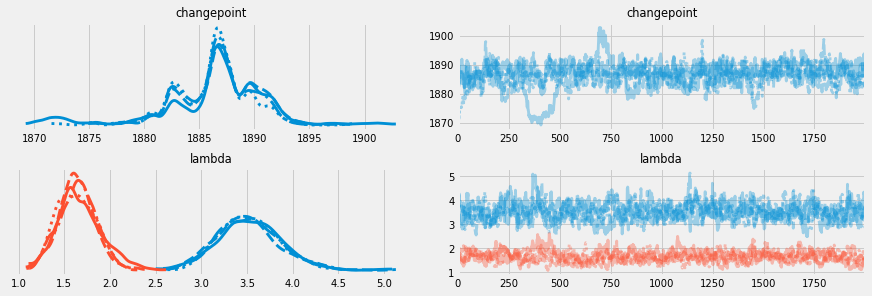

In [452]:
az.plot_trace(az.from_numpyro(mcmc));

### Joint-plot các phân phối của `changepoint`, `lambda0` và `lambda1`

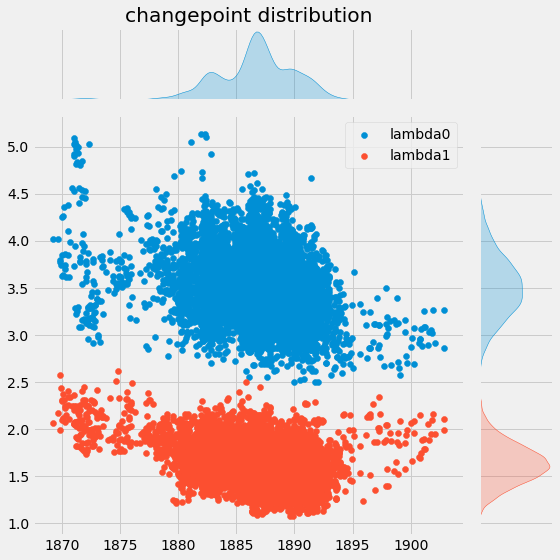

In [583]:
import seaborn as sns
fig = plt.figure(figsize=(8,8))
gs = fig.add_gridspec(6,6)
ax0 = fig.add_subplot(gs[1:,:-1])
ax0.scatter(post['changepoint'], post['lambda'][:,0], label="lambda0")
ax0.scatter(post['changepoint'], post['lambda'][:,1], label="lambda1")
ax1 = fig.add_subplot(gs[0,:-1])#,sharex=ax0)
sns.kdeplot(post['changepoint'], ax=ax1, fill=True)
ax1.set(ylabel="", yticks=[], xticklabels=[], xlim=ax0.get_xlim(), title="changepoint distribution")
ax2 = fig.add_subplot(gs[1:,-1])#, sharey=ax0)
sns.kdeplot(y=post['lambda'][:,0], ax=ax2, fill=True, legend=False)
sns.kdeplot(y=post['lambda'][:,1], ax=ax2, fill=True, legend=False)
ax2.set(xlabel="", xticks=[], yticklabels=[], ylim=ax0.get_ylim())
ax0.legend()
plt.tight_layout();

### Diễn giải posterior
Mô hình này nghĩ rằng sự thay đổi đã diễn ra trong những năm 1880-1890. Thực vậy, trung bình và khoảng 89% của nó là:

In [495]:
jnp.mean(post['changepoint'])

DeviceArray(1886.5383, dtype=float32)

In [503]:
hpdi(post['changepoint'],prob=0.89)

array([1882.0015, 1892.3856], dtype=float32)

Và tham số rate của phân phối Poisson trước và sau thời điểm đó tương ứng với:

In [504]:
jnp.mean(post['lambda'], axis=0)

DeviceArray([3.5208366, 1.6462688], dtype=float32)

Tham số lambda cũng chính là trung bình của phân phối Poisson.  
Mô hình nghĩ rằng trước thời điểm thay đổi, số ca tai nạn có trung bình là 3.5 ca.  
Còn sau thời điểm đó thì trung bình là 1.6 ca.  
Ta có thể visualize các dự đoán của nó.

### Kiểm tra lại bằng các dự đoán của mô hình vào các thời điểm trong dataset

In [535]:
df2 = pd.DataFrame({
  'changepoint': post['changepoint'][:], 
  'lambda0': post['lambda'][:,0], 
  'lambda1': post['lambda'][:,1]})

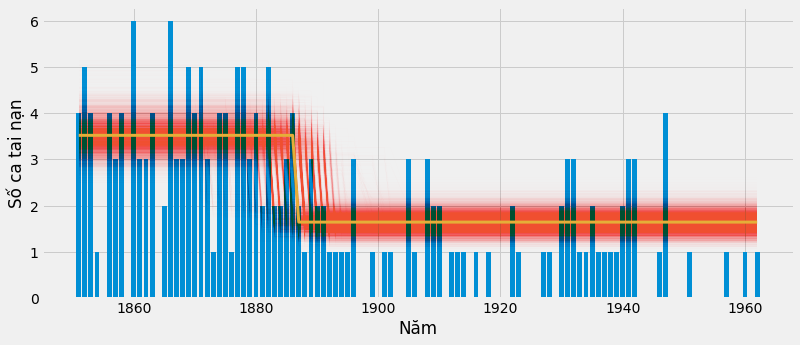

In [607]:
plt.figure(figsize=(12,5))
plt.bar(df.index, df.values)
plt.xlabel('Năm')
plt.ylabel('Số ca tai nạn')

def pl(pt, c="C1", a=0.005,lw=1):
    grp = (df.index > pt['changepoint']) * 1
    plt.plot(df.index,pt['lambda0']* (1 - grp) + pt['lambda1'] * grp, 
      color=c, alpha=a, linewidth=lw)

df2.apply(pl,axis=1)

pl(df2.mean(), c="C2", a=1, lw=3)

Biểu đồ trên chỉ thể hiện trung bình lambda, trên thực tế, còn có biến thiên do phân phối poisson.

Do đó, để mô tả toàn diện các giả định của mô hình, ta nên dùng posterior predictive plot.

In [609]:
y_pred = Predictive(model, post, return_sites=['y'])(random.PRNGKey(3), df.index.values)['y']

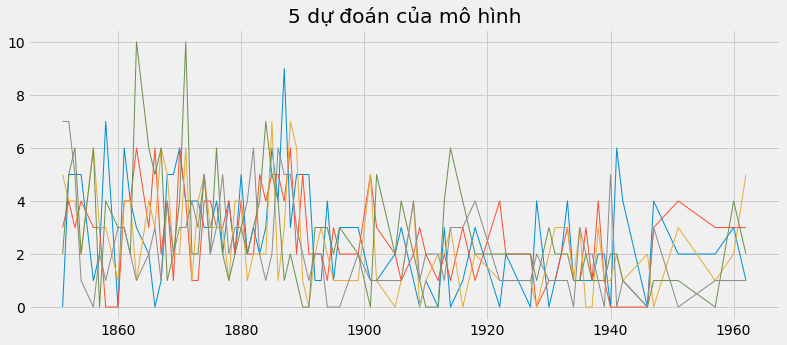

In [636]:
plt.figure(figsize=(12,5))
plt.plot(df.index, y_pred[:5].T, linewidth=1)
plt.title("5 dự đoán của mô hình");

Các bạn sẽ thấy trên thực tế, số tai nạn không chỉ dừng lại quanh con số 3 (trước T) hoặc 1.6 (sau T), mà còn có thể lên đến số 10 do biến thiên trong likelihood Poisson.

## Tổng kết:
Mô hình có thể nâng cấp lên bằng cách tăng số change points, hoặc lambda thay đổi theo thời gian ( $\lambda = \lambda + \beta \times \text{year}$). Về cơ bản, nó khá giống với biến phân nhóm (category variable), áp dùng phương pháp index vào thiết kế mô hình.

Chúc các bạn thành công.